In [278]:
#generate heatmap of correlations between metabolites and genuses with extra info about abundance

# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.stats.multitest as multitest
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt   
import re 
%matplotlib inline
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

In [279]:
#Load correlation values and pvals

corr_df = pd.read_csv('corr_df (1).csv')
corr_df.index = corr_df.columns[1:]
corr_df = corr_df.iloc[:,1:]
corr_pvalues = pd.read_csv('corr_pval (1).csv')
corr_pvalues.index = corr_pvalues.columns[1:]
corr_pvalues = corr_pvalues.iloc[:,1:]
corr_df.shape


(107, 107)

In [280]:
#Filter to have mets in index and bacteria in columns
family_names = []
corr_df = corr_df.filter(regex=("bacteria.*"), axis=1).filter(regex=("root.metabolite.*"), axis=0)
corr_pvalues = corr_pvalues.filter(regex=("bacteria.*"), axis=1).filter(regex=("root.metabolite.*"), axis=0)


In [281]:
#extract phylum
phylum_names = [ x.split('.')[1] for x in corr_df.columns.tolist()]

In [282]:
#replace names of bacteria to genus->specie, and clean met names

reg_exp_genus_specie = re.compile('[\w-]+\.[\w-]+\.[\w-]+\.[\w-]+\.(.+)')

new_cols = []
for x in corr_df.columns:
    if x.find('unclassified') >-1:
        new_cols.append(x[:x.find("unclassified")-1].split('.')[-1] + '.' + x[x.find("unclassified"):] )
    else:
        
        new_cols.append(reg_exp_genus_specie.search(x).group(1))
        
corr_df.columns = new_cols
corr_df.index = [ x.split(':')[0].split('.')[-1] for x in corr_df.index.tolist()]
corr_df.index = [ x.replace('_', ' ') for x in corr_df.index.tolist()]
corr_df.index = [ x.replace('*', '') for x in corr_df.index.tolist()]
corr_df.index=corr_df.index.to_series().replace({'alpha':'α',"beta":'β'},regex=True)

corr_df.head()

,methanobacteriaceae.methanobrevibacter,methanobacteriaceae.methanosphaera,actinomycetaceae.actinomyces,bifidobacteriaceae.bifidobacterium,coriobacteriaceae.adlercreutzia,coriobacteriaceae.collinsella,coriobacteriaceae.eggerthella,coriobacteriaceae.slackia,coriobacteriaceae.unclassified,bacteroidaceae.bacteroides,...,enterobacteriaceae.klebsiella,enterobacteriaceae.trabulsiella,enterobacteriaceae.unclassified,pasteurellaceae.haemophilus,synergistaceae.cloacibacillus,synergistaceae.synergistes,anaeroplasmataceae.unclassified,rf39.unclassified.unclassified,ml615j-28.unclassified.unclassified,verrucomicrobiaceae.akkermansia
3-(3-hydroxyphenyl)propionate,-0.089950,-0.110876,-0.030069,-0.006917,-0.045442,-0.216055,0.151967,-0.144243,-0.172286,0.193034,...,0.045227,-0.015699,0.033198,-0.004971,-0.125762,-0.105711,-0.055956,-0.121927,-0.136607,-0.072621
p-cresol sulfate,0.222401,0.084943,0.132125,0.006483,0.227915,0.133527,0.070733,0.078773,0.310859,-0.220713,...,-0.019297,-0.111136,0.022700,-0.183613,0.191302,0.134522,0.021597,0.080576,0.240319,0.295715
glycolithocholate sulfate,0.070691,-0.013855,0.066985,-0.094461,0.156266,0.054899,-0.020345,0.066150,0.177654,-0.211914,...,-0.025196,-0.060635,-0.029490,-0.176219,0.098939,0.124526,-0.001709,0.159376,0.210662,0.255291
isoursodeoxycholate,-0.263213,-0.095443,-0.095767,-0.103048,-0.159380,-0.154538,0.314961,-0.240615,-0.399495,0.371611,...,-0.028197,0.116474,0.040723,-0.167764,-0.180930,-0.126945,-0.046205,-0.295059,-0.291265,-0.133610
"5alpha-androstan-3beta,17alpha-diol disulfate",0.213774,0.131807,0.006237,0.017762,0.157378,0.132205,-0.190828,0.038892,0.322252,-0.285879,...,-0.124212,-0.076572,-0.112638,-0.077807,0.178998,0.141217,0.081541,0.258110,0.342554,0.185591


In [283]:
# mask correlations based on FDR correction
mask = np.isfinite(corr_pvalues.values)
pval_corrected = np.full(corr_pvalues.shape, np.nan)
pval_corrected[mask] = multitest.multipletests(corr_pvalues.values[mask], method='fdr_bh')[1]

pval_corrected_df = pd.DataFrame(pval_corrected, index=corr_df.index, columns=corr_df.columns)
pval_corrected_df.head()
mask_sig = (pval_corrected_df.values>0.05) | (np.isnan(pval_corrected_df.values))


In [284]:
#remove columns (bacteria) that are all insignificant (masked)
screened_corr_df = corr_df.loc[:,mask_sig.sum(axis=0)<mask_sig.shape[0]]


screened_mask_sig = mask_sig[:,mask_sig.sum(axis=0)<mask_sig.shape[0]]
screened_mask_sig_df = pd.DataFrame(data =screened_mask_sig, index =screened_corr_df.index, columns =screened_corr_df.columns   )
screened_phylum_names = [ x for x,y in zip(phylum_names, mask_sig.sum(axis=0)<mask_sig.shape[0]) if y==True]


In [285]:
# add a column with the phylum color coded
distinct20 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

series_p_names = pd.Series(screened_phylum_names)
lut = dict(zip(series_p_names.unique(), distinct20[:len(series_p_names.unique())]))
phylum_colors = series_p_names.map(lut)

cols_dict = {}
for item in zip(phylum_colors.values, series_p_names.values ):
    cols_dict[item[1]] = item[0]
    



In [286]:
#Extract abundance values
median_abundance_genus = pd.read_csv('discovery_medians.csv', header=None)
median_abundance_genus.columns = ['genus', 'median']


new_gnames = []
for x in median_abundance_genus.genus.values:
    if x.find('unclassified') >-1:
        new_gnames.append(x[:x.find("unclassified")-1].split('.')[-1] + '.' + x[x.find("unclassified"):] )
    else:
        
        new_gnames.append(reg_exp_genus_specie.search(x).group(1))
        
        
median_abundance_genus.genus = new_gnames

# Supplementary Figure 2

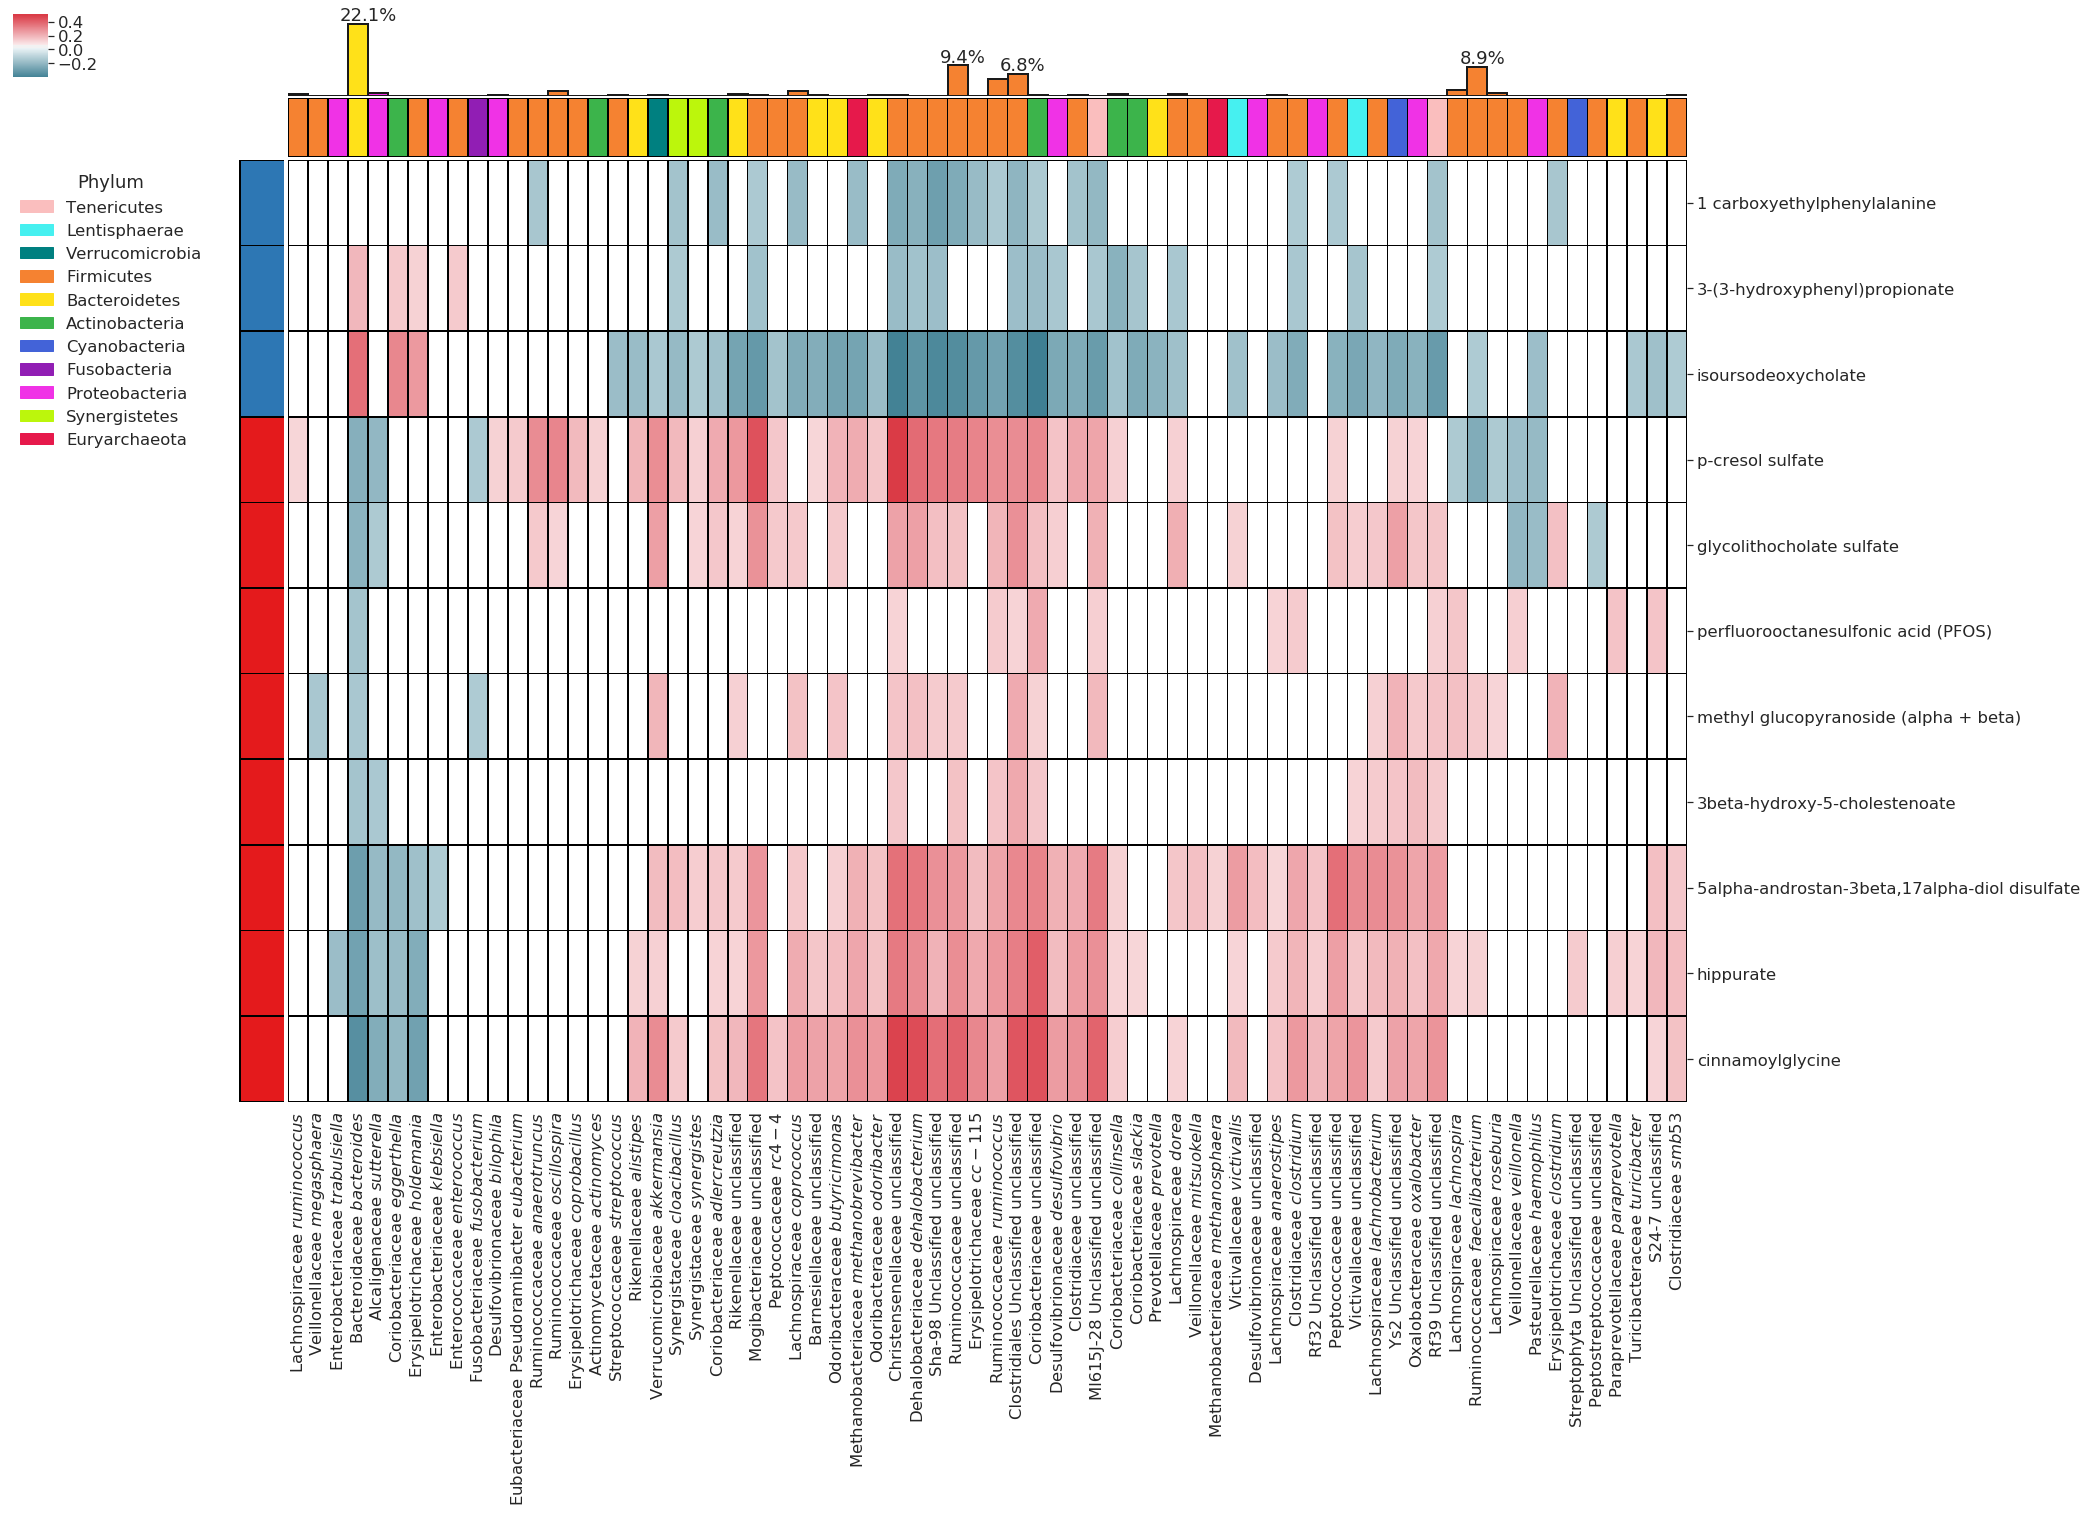

In [287]:
#And here is the heat map code:
sns.set(style="whitegrid")
sns.set(font_scale=1.5)
cmap = plt.get_cmap('Set1')
plt.rcParams['axes.facecolor'] = 'white'




cmap = sns.diverging_palette(220, 10, as_cmap=True) #'RdYlGn'
#cmap.set_bad('grey',1.)
red_tuple = '#E41A1C'
blue_tuple = '#2D77B4'

 

cg = sns.clustermap(screened_corr_df,  
                    cmap=cmap, figsize=(30, 20), 
                    metric="correlation", 
                    linecolor='black',
                    linewidths=0.5, 
                    mask = screened_mask_sig, 
                    method="complete",
                    col_colors = phylum_colors.values,
                    row_colors = [ blue_tuple,red_tuple,red_tuple,blue_tuple,red_tuple,red_tuple,blue_tuple,red_tuple,red_tuple,red_tuple,red_tuple])


#Change to italics species name




cg.ax_row_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_xlim([0,0])
#cg.ax_col_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_ylim([0,0])
patchList = []
for key in cols_dict:
        data_key = mpatches.Patch(color=cols_dict[key], label=key.title())
        patchList.append(data_key)

plt.legend(handles=patchList, loc=[0,-6], title='Phylum', frameon=False)



# Get the column dendrogram axis
cax_col_dend_ax = cg.ax_col_dendrogram.axes
plt.sca(cax_col_dend_ax.axes)
# Plot the barplot on the column dendrogram axis


from itertools import cycle, islice
import matplotlib.pyplot as plt
y_pos = np.arange(screened_corr_df.shape[1])
ordered_genuses = screened_corr_df.iloc[:,cg.dendrogram_col.reordered_ind].columns.tolist()
my_colors = list(phylum_colors.values[cg.dendrogram_col.reordered_ind]) 
abundance_df =median_abundance_genus.set_index('genus').loc[ordered_genuses,:]*1000
ax2 = cax_col_dend_ax.bar(np.arange(len(abundance_df))*10 +5, abundance_df.iloc[:,0].values, color=my_colors, width=10, linewidth = 2, edgecolor='k')
           

cg.ax_col_dendrogram.axes.set_ylim([0, 250])
cg.ax_row_colors.set_xlim([0,0])


x_offset = -9
y_offset = 10
for p in ax2.patches:
    b = p.get_bbox()
    val = "{:.1f}".format((b.y1 + b.y0)/10) + '%'
    
    if b.y1 + b.y0 >50:
        print val
        cax_col_dend_ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


#Change genera name to standard nomencalture
new_genus_names = []
for tick_label in cg.ax_heatmap.axes.get_xticklabels():
    genus_name = tick_label.get_text()
    genus_name = genus_name.replace('cc.115', 'cc-115')
    if genus_name.split(".")[-1] != 'unclassified':
        genus_name =  genus_name.rsplit('.', 1)[0] + ".$\t{" + genus_name.split(".")[-1] + "}$"
        #capitalize classes 
        
    genus_name = " ".join(genus_name.rsplit('.', 1)[0].split('.')).title() + ' ' + genus_name.rsplit('.', 1)[-1] 
    new_genus_names = new_genus_names + [genus_name.replace('.', ' ')]
cg.ax_heatmap.axes.set_xticklabels(new_genus_names)


# Show the plot
plt.show()
cg.savefig('dis_cors.png', dpi=300)


# Figure 3

In [288]:
#determine the top abundance phyla
top_abund = abundance_df.sort_values(by='median', ascending  = False)[:10]
subset_corr_df = screened_corr_df[top_abund.index.tolist()]
screened_mask_sig_subset = screened_mask_sig_df[top_abund.index.tolist()].values

In [289]:
#extract their data
screened_phylum_names_subset_df = pd.DataFrame(data = screened_phylum_names, index = screened_corr_df.columns)
screened_phylum_names_subset_df = screened_phylum_names_subset_df.loc[top_abund.index.tolist()].values
series_p_names_subset = pd.Series(screened_phylum_names_subset_df.flatten())
lut_subset = dict(zip(series_p_names_subset.unique(), distinct20[:len(series_p_names_subset.unique())]))
phylum_colors_subset = series_p_names_subset.map(lut)

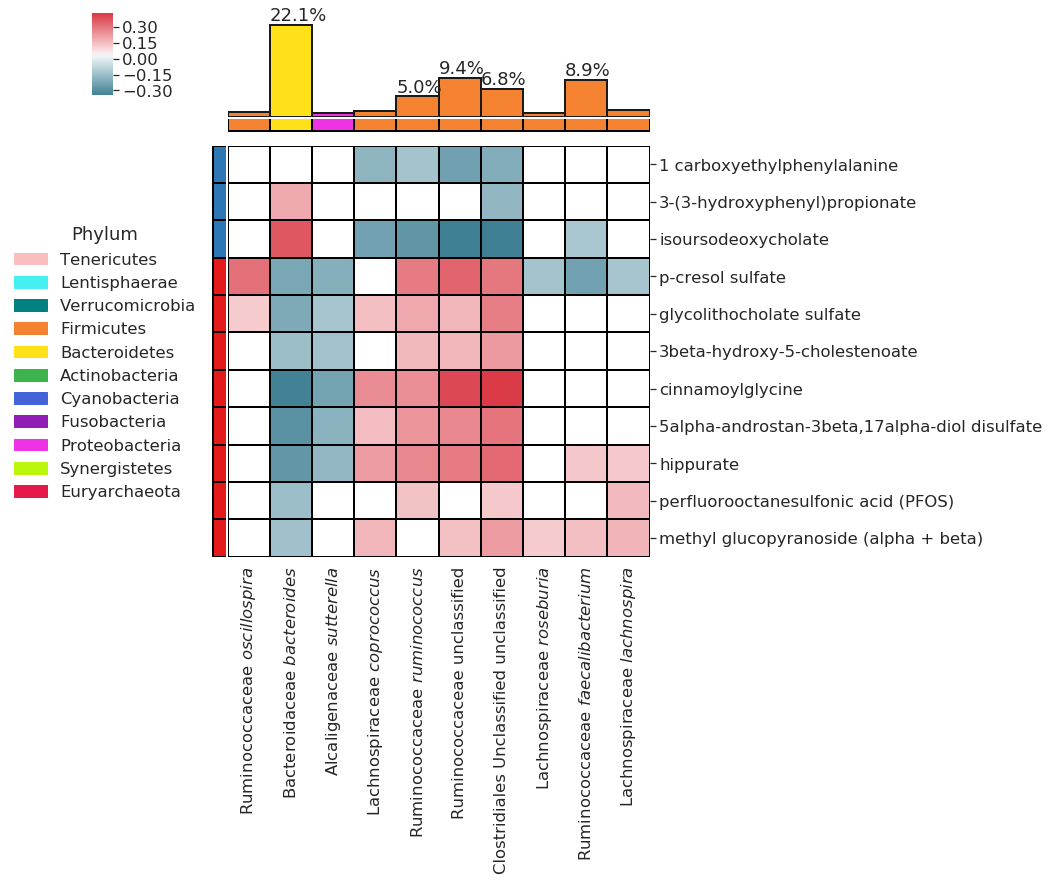

In [290]:
#And here is the heat map code:
sns.set(style="whitegrid")
sns.set(font_scale=1.5)
cmap = plt.get_cmap('Set1')
plt.rcParams['axes.facecolor'] = 'white'




cmap = sns.diverging_palette(220, 10, as_cmap=True) #'RdYlGn'
#cmap.set_bad('grey',1.)
red_tuple = '#E41A1C'
blue_tuple = '#2D77B4'
cg = sns.clustermap(subset_corr_df,  
                    cmap=cmap, figsize=(10, 10), 
                    metric="correlation", 
                    linecolor='black',
                    linewidths=1, 
                    mask = screened_mask_sig_subset, 
                    method="complete",
                    col_colors = phylum_colors_subset.values,                    
                    row_colors = [ blue_tuple,red_tuple,red_tuple,blue_tuple,red_tuple,red_tuple,blue_tuple,red_tuple,red_tuple,red_tuple,red_tuple])
cg.ax_row_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_xlim([0,0])
#cg.ax_col_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_ylim([0,0])
patchList = []
for key in cols_dict:
        data_key = mpatches.Patch(color=cols_dict[key], label=key.title())
        patchList.append(data_key)

plt.legend(handles=patchList, loc=[-4,-5], title='Phylum', frameon=False)



# Get the column dendrogram axis
cax_col_dend_ax = cg.ax_col_dendrogram.axes
plt.sca(cax_col_dend_ax.axes)
# Plot the boxplot on the column dendrogram axis
# I still need to figure out how to show the axis for this boxplot

from itertools import cycle, islice
import matplotlib.pyplot as plt
y_pos = np.arange(subset_corr_df.shape[1])
ordered_genuses = subset_corr_df.iloc[:,cg.dendrogram_col.reordered_ind].columns.tolist()
my_colors = list(phylum_colors_subset.values[cg.dendrogram_col.reordered_ind]) 
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, 70))
abundance_df =median_abundance_genus.set_index('genus').loc[ordered_genuses,:]*1000
ax2 = cax_col_dend_ax.bar(np.arange(len(abundance_df))*10+5, abundance_df.iloc[:,0].values, color=my_colors, width=10, linewidth = 2, edgecolor='k')
        

cg.ax_col_dendrogram.axes.set_ylim([0, 250])
cg.ax_row_colors.set_xlim([0,0])
cg.ax_col_colors.set_ylim([0,0])



x_offset = -5
y_offset = 10
for p in ax2.patches:
    b = p.get_bbox()
    val = "{:.1f}".format((b.y1 + b.y0)/10) + '%'
    
    if b.y1 + b.y0 >40:
        print val
        cax_col_dend_ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#Change genera name to standard nomencalture
new_genus_names = []
for tick_label in cg.ax_heatmap.axes.get_xticklabels():
    genus_name = tick_label.get_text()
    genus_name = genus_name.replace('cc.115', 'cc-115')
    if genus_name.split(".")[-1] != 'unclassified':
        genus_name =  genus_name.rsplit('.', 1)[0] + ".$\t{" + genus_name.split(".")[-1] + "}$"
        #capitalize classes 
        
    genus_name = " ".join(genus_name.rsplit('.', 1)[0].split('.')).title() + ' ' + genus_name.rsplit('.', 1)[-1] 
    new_genus_names = new_genus_names + [genus_name.replace('.', ' ')]
cg.ax_heatmap.axes.set_xticklabels(new_genus_names)


# Show the plot
plt.show()

cg.savefig('main_text_fig.png', dpi=300, bbox_inches='tight', pad_inches=0)


# Supplementary Figure 6

In [291]:
# screen the table with only the mets & genuses from the discovery cohort

#load correlations for validation cohort

corr_df_validation = pd.read_csv('corr_df_validation-2.csv')
pval_df_validation = pd.read_csv('corr_pval_validation-2.csv')

In [292]:
corr_df_validation.index = corr_df_validation.columns[1:]
corr_df_validation = corr_df_validation.iloc[:,1:]

pval_df_validation.index = pval_df_validation.columns[1:]
pval_df_validation = pval_df_validation.iloc[:,1:]

In [293]:
corr_df_validation.shape

(114, 114)

In [294]:
#Filter to have mets in index and bacteria in columns
family_names = []
corr_df_validation = corr_df_validation.filter(regex=("bacteria.*"), axis=1).filter(regex=("root.metabolite.*"), axis=0)
corr_df_validation = corr_df_validation.filter(regex=("bacteria.*"), axis=1).filter(regex=("root.metabolite.*"), axis=0)

pval_df_validation = pval_df_validation.filter(regex=("bacteria.*"), axis=1).filter(regex=("root.metabolite.*"), axis=0)
pval_df_validation = pval_df_validation.filter(regex=("bacteria.*"), axis=1).filter(regex=("root.metabolite.*"), axis=0)


#extract phylum
phylum_names = [ x.split('.')[1] for x in corr_df_validation.columns.tolist()]

#replace names of bacteria to genus->specie, and clean met names

reg_exp_genus_specie = re.compile('[\w-]+\.[\w-]+\.[\w-]+\.[\w-]+\.(.+)')


new_cols = []
for x in corr_df_validation.columns:
    if x.find('unclassified') >-1:
        new_cols.append(x[:x.find("unclassified")-1].split('.')[-1] + '.' + x[x.find("unclassified"):] )
    else:
        
        new_cols.append(reg_exp_genus_specie.search(x).group(1))
        
        
    


corr_df_validation.columns = new_cols
corr_df_validation.index = [ x.split(':')[0].split('.')[-1] for x in corr_df_validation.index.tolist()]
corr_df_validation.index = [ x.replace('_', ' ') for x in corr_df_validation.index.tolist()]
corr_df_validation.index=corr_df_validation.index.to_series().replace({'alpha':'α',"beta":'β'},regex=True)
corr_df_validation.index = [ x.replace('*', '') for x in corr_df_validation.index.tolist()]

corr_df_validation.head()

pval_df_validation.columns = corr_df_validation.columns
pval_df_validation.index = corr_df_validation.index



In [295]:
# filter the rows & columns that we had in the discovery cohort (screened_corr_df)
new_index = [ x for x in screened_corr_df.index if x in corr_df_validation.index ] #11
new_cols = [ x for x in screened_corr_df.columns if x in corr_df_validation.columns ] #64

In [296]:
screened_corr_df_validation = corr_df_validation.loc[new_index,new_cols ]
screened_pval_df_validation = pval_df_validation.loc[new_index,new_cols]

In [297]:
only_sig_discovery = screened_mask_sig_df[[ x for x in screened_mask_sig_df.columns if x in screened_corr_df_validation.columns]]

In [298]:
only_sig_discovery

,methanobacteriaceae.methanobrevibacter,methanobacteriaceae.methanosphaera,actinomycetaceae.actinomyces,coriobacteriaceae.adlercreutzia,coriobacteriaceae.collinsella,coriobacteriaceae.eggerthella,coriobacteriaceae.slackia,coriobacteriaceae.unclassified,bacteroidaceae.bacteroides,barnesiellaceae.unclassified,...,oxalobacteraceae.oxalobacter,desulfovibrionaceae.bilophila,desulfovibrionaceae.desulfovibrio,desulfovibrionaceae.unclassified,pasteurellaceae.haemophilus,synergistaceae.cloacibacillus,synergistaceae.synergistes,rf39.unclassified.unclassified,ml615j-28.unclassified.unclassified,verrucomicrobiaceae.akkermansia
3-(3-hydroxyphenyl)propionate,True,True,True,True,False,False,False,False,False,True,...,True,True,False,True,True,False,True,False,False,True
p-cresol sulfate,False,True,False,False,False,True,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
glycolithocholate sulfate,True,True,True,False,True,True,True,False,False,True,...,False,True,False,True,False,True,False,False,False,False
isoursodeoxycholate,False,True,True,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False
"5alpha-androstan-3beta,17alpha-diol disulfate",False,False,True,False,False,False,True,False,False,True,...,False,True,False,False,True,False,False,False,False,False
3beta-hydroxy-5-cholestenoate,True,True,True,True,True,True,True,False,False,True,...,False,True,True,True,True,True,True,False,True,True
1 carboxyethylphenylalanine,False,True,True,False,True,True,True,False,True,True,...,True,True,True,True,True,False,True,False,False,True
hippurate,False,True,True,False,False,False,False,False,False,False,...,False,True,False,True,True,True,True,False,False,False
perfluorooctanesulfonic acid (PFOS),True,True,True,True,True,True,True,False,False,True,...,True,True,True,True,True,True,True,False,False,True
cinnamoylglycine,False,True,True,False,False,False,True,False,False,False,...,False,True,False,True,True,False,True,False,False,False


In [299]:
screened_pval_df_validation.values.shape

(11, 64)

In [300]:
# Look and correct ONLY BASED ON THE PAIRS THAT WERE SIGNIFICANT IN THE DISCOVERY COHORT
mask_val = only_sig_discovery.values
pval_corrected_val = np.full(screened_pval_df_validation.shape, np.nan)
pval_corrected_val[~mask_val] = multitest.multipletests(screened_pval_df_validation.values[~mask_val], method='fdr_bh')[1]

pval_corrected_df_val = pd.DataFrame(pval_corrected_val, index=screened_corr_df_validation.index, columns=screened_corr_df_validation.columns)
pval_corrected_df_val.head()
mask_sig_val = (pval_corrected_df_val.values>0.05) | (np.isnan(pval_corrected_df_val.values))

In [301]:
#remove columns (bacteria) that are all insignificant (masked)
screened_corr_df_plotting = screened_corr_df_validation # screened_corr_df_validation.loc[:,mask_sig_val.sum(axis=0)<mask_sig_val.shape[0]]
screened_mask_sig_val = mask_sig_val #mask_sig_val[:,mask_sig_val.sum(axis=0)<mask_sig_val.shape[0]]
screened_mask_sig_val_df = pd.DataFrame(data =screened_mask_sig_val, index =screened_corr_df_plotting.index, columns =screened_corr_df_plotting.columns   )
#screened_phylum_names_val = [ x for x,y in zip(phylum_names, mask_sig_val.sum(axis=0)<mask_sig_val.shape[0]) if y==True]



In [302]:
screened_mask_sig_val_df

,methanobacteriaceae.methanobrevibacter,methanobacteriaceae.methanosphaera,actinomycetaceae.actinomyces,coriobacteriaceae.adlercreutzia,coriobacteriaceae.collinsella,coriobacteriaceae.eggerthella,coriobacteriaceae.slackia,coriobacteriaceae.unclassified,bacteroidaceae.bacteroides,barnesiellaceae.unclassified,...,oxalobacteraceae.oxalobacter,desulfovibrionaceae.bilophila,desulfovibrionaceae.desulfovibrio,desulfovibrionaceae.unclassified,pasteurellaceae.haemophilus,synergistaceae.cloacibacillus,synergistaceae.synergistes,rf39.unclassified.unclassified,ml615j-28.unclassified.unclassified,verrucomicrobiaceae.akkermansia
3-(3-hydroxyphenyl)propionate,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,False,False,True
p-cresol sulfate,False,True,False,False,True,True,True,False,True,True,...,False,False,False,True,False,False,True,True,False,False
glycolithocholate sulfate,True,True,True,True,True,True,True,False,False,True,...,False,True,False,True,True,True,True,False,False,False
isoursodeoxycholate,False,True,True,True,True,False,True,False,False,True,...,False,True,True,True,False,False,True,False,False,False
"5alpha-androstan-3beta,17alpha-diol disulfate",False,False,True,True,False,False,True,False,False,True,...,False,True,False,True,True,False,True,False,False,True
3beta-hydroxy-5-cholestenoate,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1 carboxyethylphenylalanine,True,True,True,False,True,True,True,False,True,True,...,True,True,True,True,True,True,True,True,True,True
hippurate,False,True,True,False,True,False,True,False,False,False,...,False,True,False,True,True,True,True,False,False,False
perfluorooctanesulfonic acid (PFOS),True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
cinnamoylglycine,False,True,True,False,True,False,True,False,False,False,...,False,True,False,True,True,False,True,False,False,False


In [303]:
#Extract abundance values
median_abundance_genus = pd.read_csv('Validation_compositional_microbiome-3.csv', header=None)
median_abundance_genus.columns = ['genus', 'median']


new_gnames = []
for x in median_abundance_genus.genus.values:
    if x.find('unclassified') >-1:
        new_gnames.append(x[:x.find("unclassified")-1].split('.')[-1] + '.' + x[x.find("unclassified"):] )
    else:
        
        new_gnames.append(reg_exp_genus_specie.search(x).group(1))
        
        
median_abundance_genus.genus = new_gnames

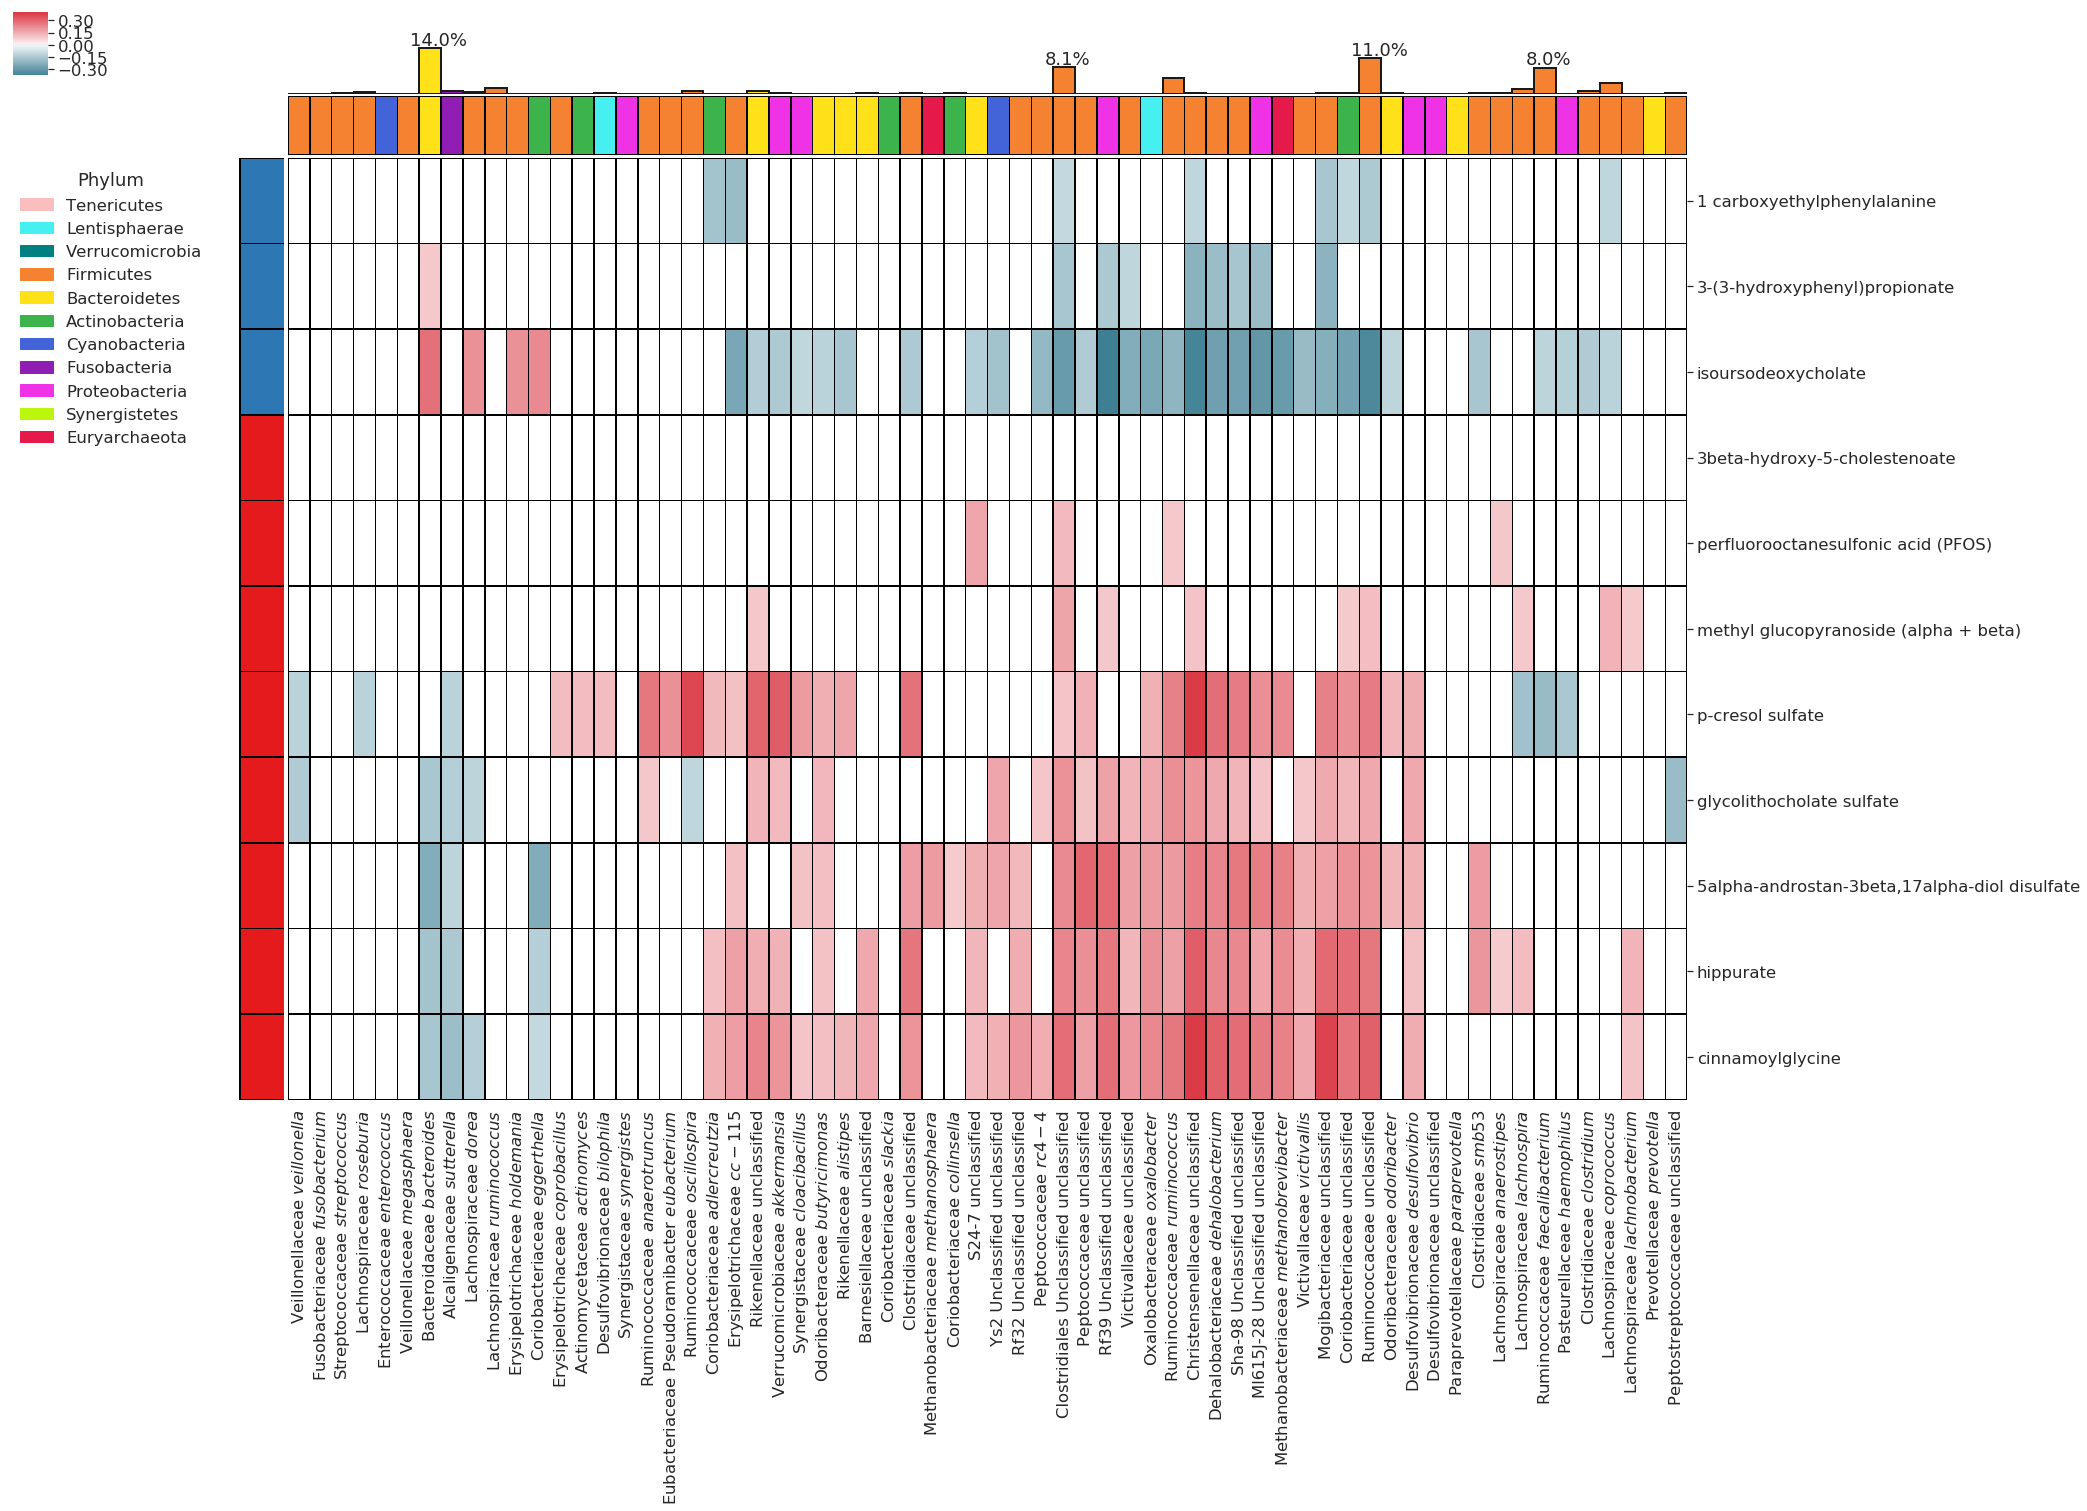

In [304]:
#And here is the heat map code:
sns.set(style="whitegrid")
sns.set(font_scale=1.5)
cmap = plt.get_cmap('Set1')
plt.rcParams['axes.facecolor'] = 'white'




cmap = sns.diverging_palette(220, 10, as_cmap=True) #'RdYlGn'
#cmap.set_bad('grey',1.)
red_tuple = '#E41A1C'
blue_tuple = '#2D77B4'
cg = sns.clustermap(screened_corr_df_plotting,  
                    cmap=cmap, figsize=(30, 20), 
                    metric="correlation", 
                    linecolor='black',
                    linewidths=0.5, 
                    mask = screened_mask_sig_val, 
                    method="complete",
                    col_colors = phylum_colors.values,
                    
                    row_colors = [ blue_tuple,red_tuple,red_tuple,blue_tuple,red_tuple,red_tuple,blue_tuple,red_tuple,red_tuple,red_tuple,red_tuple])
cg.ax_row_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_xlim([0,0])
#cg.ax_col_dendrogram.set_visible(False)
#cg.ax_col_dendrogram.set_ylim([0,0])
patchList = []
for key in cols_dict:
        data_key = mpatches.Patch(color=cols_dict[key], label=key.title())
        patchList.append(data_key)

plt.legend(handles=patchList, loc=[0,-6], title='Phylum', frameon=False)



# Get the column dendrogram axis
cax_col_dend_ax = cg.ax_col_dendrogram.axes
plt.sca(cax_col_dend_ax.axes)
# Plot the barplot on the column dendrogram axis


from itertools import cycle, islice
import matplotlib.pyplot as plt
y_pos = np.arange(screened_corr_df_plotting.shape[1])
ordered_genuses = screened_corr_df_plotting.iloc[:,cg.dendrogram_col.reordered_ind].columns.tolist()
my_colors = list(phylum_colors.values[cg.dendrogram_col.reordered_ind]) 
abundance_df =median_abundance_genus.set_index('genus').loc[ordered_genuses,:]*1000
ax2 = cax_col_dend_ax.bar(np.arange(len(abundance_df))*10+5, abundance_df.iloc[:,0].values, color=my_colors, width=10, linewidth = 2, edgecolor='k')
           

cg.ax_col_dendrogram.axes.set_ylim([0, 250])
cg.ax_row_colors.set_xlim([0,0])


x_offset = -9
y_offset = 10
for p in ax2.patches:
    b = p.get_bbox()
    val = "{:.1f}".format((b.y1 + b.y0)/10) + '%'
    
    if b.y1 + b.y0 >50:
        print val
        cax_col_dend_ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#Change genera name to standard nomencalture
new_genus_names = []
for tick_label in cg.ax_heatmap.axes.get_xticklabels():
    genus_name = tick_label.get_text()
    genus_name = genus_name.replace('cc.115', 'cc-115')
    if genus_name.split(".")[-1] != 'unclassified':
        genus_name =  genus_name.rsplit('.', 1)[0] + ".$\t{" + genus_name.split(".")[-1] + "}$"
        #capitalize classes 
        
    genus_name = " ".join(genus_name.rsplit('.', 1)[0].split('.')).title() + ' ' + genus_name.rsplit('.', 1)[-1] 
    new_genus_names = new_genus_names + [genus_name.replace('.', ' ')]
cg.ax_heatmap.axes.set_xticklabels(new_genus_names)
        
        
# Show the plot
plt.show()
cg.savefig('val_cors.png', dpi=300)




In [305]:
screened_corr_df_plotting.shape

(11, 64)

In [306]:
count_corrs = pd.DataFrame(columns = ['Discovery', 'Validation'], index =screened_corr_df_plotting.index )
count_corrs.Validation = np.sum(~mask_sig_val, axis=1)
count_corrs.Discovery = np.sum(~screened_mask_sig, axis=1)
count_corrs= count_corrs.reset_index()
count_corrs.columns = ['Metabolite','Discovery', 'Validation']

In [307]:
count_corrs

,Metabolite,Discovery,Validation
0,3-(3-hydroxyphenyl)propionate,19,9
1,p-cresol sulfate,43,34
2,glycolithocholate sulfate,33,27
3,isoursodeoxycholate,46,35
4,"5alpha-androstan-3beta,17alpha-diol disulfate",43,30
5,3beta-hydroxy-5-cholestenoate,12,0
6,1 carboxyethylphenylalanine,20,8
7,hippurate,45,32
8,perfluorooctanesulfonic acid (PFOS),13,4
9,cinnamoylglycine,41,34


In [308]:
print float(count_corrs.Validation.sum())/count_corrs.Discovery.sum()*100.0
#222.0/337*100

In [309]:
float(count_corrs.Validation.sum())

222.0

In [310]:
count_corrs.Discovery.sum()

337

# Supplementary figure 7

<Figure size 1500x1800 with 0 Axes>

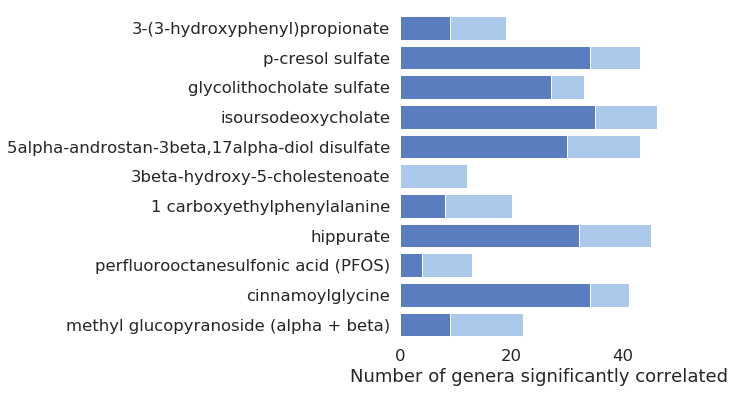

In [311]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=[5,6], dpi=300)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5, 6))



# Plot the total 
sns.set_color_codes("pastel")
sns.barplot(x="Discovery", y="Metabolite", data=count_corrs,
            label="Discovery", color="b", orient = "h")

# Plot home many validated out of the discovery set
sns.set_color_codes("muted")
sns.barplot(x="Validation", y="Metabolite", data=count_corrs,
            label="Validation", color="b", orient = "h")

# Add a legend and informative axis label
ax.set(xlim=(0, 50), ylabel="",
       xlabel="Number of genera significantly correlated")
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
sns.despine(left=True, bottom=True)




In [312]:
f.savefig('val_nums.png', dpi=300, bbox_inches='tight', pad_inches=0)